In [1]:
import torch                          # Le cœur de PyTorch : tensors, calculs, GPU
import torch.nn as nn                 # Contient toutes les couches du réseau (Conv2D, Linear, etc.)
import torch.optim as optim           # Optimiseurs pour entraîner le modèle (Adam, SGD, etc.)
from torch.utils.data import DataLoader  # Pour gérer le batching et le shuffle des datasets
from torch.utils.data import random_split
from torchvision import datasets, transforms, models  # Outils pour datasets, transformations et modèles pré-entraînés
from torch import tensor

import numpy as np                    # Manipulation de tableaux, conversion images → tensors
import pandas as pd                   # Pour lire et écrire le fichier test_template.csv
import os                             # Gestion des fichiers et dossiers

# -----------------------------
# Librairies pour la visualisation
# -----------------------------
import matplotlib.pyplot as plt       # Visualiser les images et tracer des courbes

# -----------------------------
# Librairies pour la vision par ordinateur
# -----------------------------
import cv2                            # Capturer la webcam et détecter les visages
from PIL import Image 
from skimage import io
import matplotlib.pyplot as plt
import os, random

Text(0.5, 1.0, 'neutral')

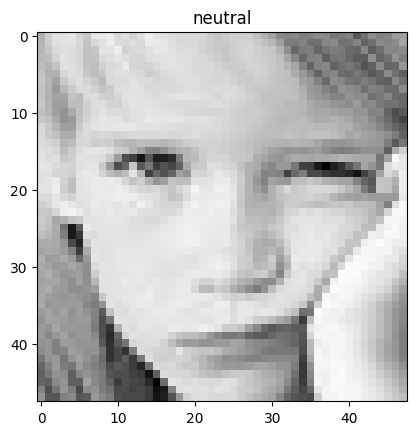

In [2]:
emotions = ['neutral', 'angry', 'fear', 'happy', 'sad', 'surprise', 'disgust']
emotion = 'neutral'
x = random.randint(0, 6)
path = f'data/dataTrain/train/{emotion}/'
img = io.imread(os.path.join(path, random.choice(os.listdir(path))))
plt.imshow(img, cmap='gray')
plt.title(emotion)
# plt.show()

In [3]:
import os

for emotion in os.listdir('data/dataTrain/train'):
    print(emotion, ":", len(os.listdir(os.path.join('data/dataTrain/train', emotion))))


happy : 7215
sad : 4830
fear : 4097
surprise : 3171
neutral : 4965
angry : 3995
disgust : 436


In [4]:
#Éviter le changement dans validation (on veut avoir les images réels)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),        # rotation ±10°
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # zoom léger
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

train_data = datasets.ImageFolder("data/dataTrain/train", transform=train_transform)
val_data   = datasets.ImageFolder("data/dataTrain/train", transform=val_transform)
test_data  = datasets.ImageFolder("data/dataTest", transform=val_transform)


In [ ]:
# Split train / validation
train_size = int(0.8 * len(train_data))
validation_size = len(train_data) - train_size
train_dataset, validation_dataset = random_split(train_data, [train_size, validation_size])

# ⚠️ Remplacer le dataset de validation par celui sans augmentation
validation_dataset.dataset = val_data

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # 128 trop aggressif au debut 
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)


In [6]:
# --- Modèle : ResNet18 fine-tuning ---
modeleEmotions = models.resnet18(pretrained=True)

#degele aussi layer 3 (avant que 4) 
for name, param in modeleEmotions.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

nbEmotions = 7
modeleEmotions.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(512, nbEmotions)
)


print(modeleEmotions) # Modèle de classification des émotions


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Users/massylia/Desktop/HackatonCodeML-main/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/massylia/Desktop/HackatonCodeML-main/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#loss function on ne veut pas geler toutes les couches. Sinon, le modele s'ameliore trop lentement
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
modeleEmotions = modeleEmotions.to(device)

# --- Optimiseur:recopies / recoles la ligne de l’optimizer juste après avoir changé requires_grad.
# (pour que l’optimizeur reconnaisse les nouvelles couches )---
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, modeleEmotions.parameters()),
    lr=1e-4
)

# Scheduler qui réduit le learning rate. eviter stagnation 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # surveille la val_loss
    factor=0.5,          # réduit LR de moitié
    patience=1,          # attend 1 epoch avant de réduire
)

criterion = nn.CrossEntropyLoss()

In [8]:
#sanity check
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

outputs = modeleEmotions(images)
print("outputs shape:", outputs.shape)   # doit être (64, 7) ou (dernier batch, 7)
print("labels shape:", labels.shape)     # doit être (64,) ou (dernier batch,)
print("labels dtype:", labels.dtype)     # doit être torch.int64 (Long)
print("labels min/max:", labels.min().item(), labels.max().item())  # doit être 0..6

outputs shape: torch.Size([64, 7])
labels shape: torch.Size([64])
labels dtype: torch.int64
labels min/max: 0 6


In [ ]:
num_epochs = 10

def run_one_epoch(model, loader, training: bool):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.set_grad_enabled(training):
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            if training:
                optimizer.zero_grad()

            outputs = model(images)              # (batch, nbEmotions)
            loss = criterion(outputs, labels)

            if training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


# --- Boucle principale ---
for epoch in range(num_epochs):
    train_loss, train_acc = run_one_epoch(modeleEmotions, train_loader, training=True)
    val_loss, val_acc = run_one_epoch(modeleEmotions, validation_loader, training=False)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f} acc {val_acc:.4f}")

scheduler.step(val_loss) #éviter stagnation

Epoch 1/10 | Train loss 1.3441 acc 0.4970 | Val loss 1.0847 acc 0.5787
Epoch 2/10 | Train loss 1.0664 acc 0.6001 | Val loss 1.0533 acc 0.6082
Epoch 3/10 | Train loss 0.9683 acc 0.6404 | Val loss 0.9778 acc 0.6217
Epoch 4/10 | Train loss 0.8954 acc 0.6682 | Val loss 0.9696 acc 0.6407
Epoch 5/10 | Train loss 0.8208 acc 0.6938 | Val loss 0.9712 acc 0.6350
Epoch 6/10 | Train loss 0.7614 acc 0.7184 | Val loss 0.9605 acc 0.6526
Epoch 7/10 | Train loss 0.6973 acc 0.7436 | Val loss 0.9729 acc 0.6543


KeyboardInterrupt: 